In [37]:
import sys, math, os
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt    
import numpy as np
import statsmodels.formula.api as sm
import scipy.stats
from sklearn import linear_model
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import operator

sys.path.insert(0, '../../src/data/')
import utils

%matplotlib inline
%load_ext autoreload  
%autoreload 2  

path_raw = "../../data/raw/beer_reviews"
trolls_file = '../../data/interim/trolls.csv'
random = 42

savefig = False

assert os.path.isfile(os.path.join(path_raw, 'beer_reviews.csv')), "This data file doesn't exist yet, please run through 'make data'"
assert os.path.isfile(trolls_file), "The trolls file doesn't exist yet, please run through analysis 3.0 first!"

# ignore sklearn depreciation warnings :(
import warnings
warnings.filterwarnings('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Quick way of getting the notebook name, see [here](https://stackoverflow.com/a/23619544/1153897) for source; notebook name will be in python variable `notebook`.

In [3]:
%%javascript
var kernel = IPython.notebook.kernel;
var thename = window.document.getElementById("notebook_name").innerHTML;
var command = "notebook = " + "'"+thename+"'";
kernel.execute(command);

<IPython.core.display.Javascript object>

# Introduction

The goal of this notebook is to try and answer the question
> If I enjoy a beer's aroma and appearance, which beer style should I try?

In other words, which beer style in general have the highest scores in `review_aroma` and `review_appearance`?

In [4]:
# LOAD DATA
# we assume the file we're after is a
# single .csv in path_raw
for file in os.listdir(path_raw):
    file = os.path.join(path_raw, file)
    if os.path.isfile(file) and '.csv' in file: 
        dat_raw = pd.read_csv(file, encoding='utf-8') # NOTE: force utf-8 encoding because some beer_styles have accents in them
        
# this file only available if analysis 3.0 is run
trolls = pd.read_csv(trolls_file)

# create new copy of data
# 1. without reviews with missing profilename
# 2. without trolls
dat = dat_raw[(dat_raw.review_profilename.notnull()) & (~dat_raw.review_profilename.isin(trolls))].copy()

# generate new feature as the mean of review_aroma and review_appearance
dat['combo_score'] = dat[['review_aroma', 'review_appearance']].mean(axis=1)

<hr>

In [5]:
# for each beer style, get some descriptive stats for the interested factors
factors = ['review_aroma', 'review_appearance']
label = ['beer_style']
factor_stats = dat[factors + ['combo_score'] + label].groupby('beer_style').agg(['mean','median','std','count','max'])


# naivly sort by mean score and grab top10
factor_stats.sort_values(('combo_score','mean'), ascending=False).head(10)

review_aroma                               \
                                         mean median       std  count  max   
beer_style                                                                   
American Double / Imperial Stout     4.160604    4.0  0.570494  50696  5.0   
Russian Imperial Stout               4.076571    4.0  0.542298  54120  5.0   
Quadrupel (Quad)                     4.132493    4.0  0.544134  18084  5.0   
American Double / Imperial IPA       4.097774    4.0  0.568202  85958  5.0   
Gueuze                               4.117696    4.0  0.560120   6007  5.0   
American Wild Ale                    4.126756    4.0  0.565143  17794  5.0   
Eisbock                              4.156778    4.0  0.528950   2663  5.0   
American Barleywine                  4.019348    4.0  0.524654  26721  5.0   
Belgian IPA                          3.979666    4.0  0.511232  12467  5.0   
Weizenbock                           4.044677    4.0  0.519257   9412  5.0   

                                 review_appearance                          \
                                              mean median       std  count   
beer_style                                                                   
American Double / Imperial Stout          4.163563    4.0  0.515692  50696   
Russian Imperial Stout                    4.210070    4.0  0.508619  54120   
Quadrupel (Quad)                          4.117922    4.0  0.514125  18084   
American Double / Imperial IPA            4.078882    4.0  0.469201  85958   
Gueuze                                    4.034876    4.0  0.500074   6007   
American Wild Ale                         4.005451    4.0  0.501612  17794   
Eisbock                                   3.964514    4.0  0.496758   2663   
American Barleywine                       4.036376    4.0  0.478667  26721   
Belgian IPA                               4.075199    4.0  0.481009  12467   
Weizenbock                                4.009297    4.0  0.510222   9412   

                                      combo_score                               
                                  max        mean median       std  count  max  
beer_style                                                                      
American Double / Imperial Stout  5.0    4.162084   4.25  0.446933  50696  5.0  
Russian Imperial Stout            5.0    4.143320   4.25  0.434802  54120  5.0  
Quadrupel (Quad)                  5.0    4.125207   4.25  0.448639  18084  5.0  
American Double / Imperial IPA    5.0    4.088328   4.00  0.430182  85958  5.0  
Gueuze                            5.0    4.076286   4.25  0.450927   6007  5.0  
American Wild Ale                 5.0    4.066104   4.00  0.442322  17794  5.0  
Eisbock                           5.0    4.060646   4.00  0.412955   2663  5.0  
American Barleywine               5.0    4.027862   4.00  0.408577  26721  5.0  
Belgian IPA                       5.0    4.027432   4.00  0.402156  12467  5.0  
Weizenbock                        5.0    4.026987   4.00  0.427077   9412  5.0

The beers above show those that are both highly rated (on average) in aroma and appearance -> these numbers suggest *American Double / Imperial Stout* be the `beet_style` to recommend. It should be noted that *American Double / Imperial IPA* was reviewed more than any other beer, and thus we can be more confident in scores attributed to this beer.

In [6]:
ranks = dict()
for cutoff in np.arange(4.0,5.1,0.1):
    
    # pull out only those reviews with a score of >= 'cutoff' for aroma and appearance
    score5 = dat[(dat.review_aroma>=cutoff) & (dat.review_appearance>=cutoff)]
    score5_group = score5.groupby('beer_style').count()[['brewery_id']]
    score5_group.columns = ['count_perfect_reviews']

    # get number of reviews for each beer_style
    reviews = dat.groupby('beer_style').count()[['brewery_id']]
    reviews.columns = ['count_reviews']

    # get number of beers per style
    num_beers = dat.groupby('beer_beerid').agg('first').groupby('beer_style').count()[['brewery_id']]
    num_beers.columns = ['count_beers']

    # merge
    score5_group = score5_group.merge(reviews, left_index=True, right_index=True, how='inner')
    score5_group = score5_group.merge(num_beers, left_index=True, right_index=True, how='inner')

    # sort
    score5_group = score5_group.sort_values('count_perfect_reviews', ascending=False).head(10)

    # NOTE: rank 0 is highest
    rank = {str(style):rank for rank,style in enumerate(score5_group.index.tolist())}
    
    ranks[cutoff] = rank

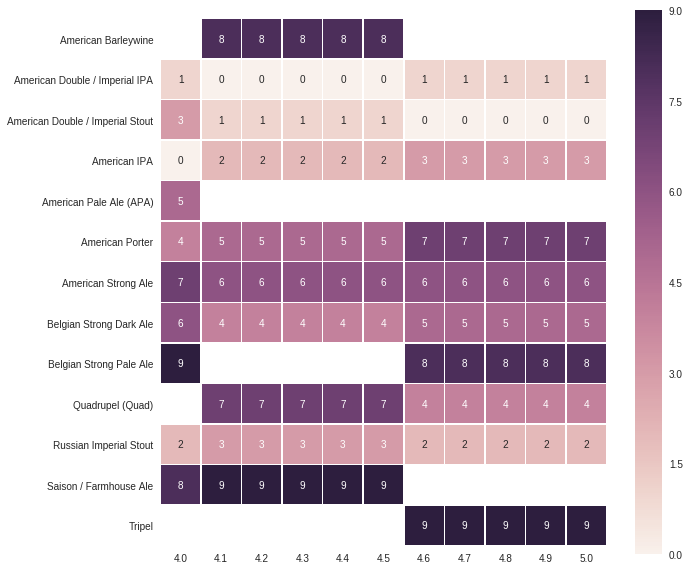

In [7]:
ratings = pd.DataFrame(ranks)

plt.figure(figsize=(10,10))
with sns.axes_style("white"):
    sns.heatmap(ratings, linewidths=.5, square=True, mask=ratings.isnull(), annot=True)
    
if savefig: utils.autosave_fig(notebook)

The heatmap above shows how the highest rated `beer_style` rank (0 is highest rank) as the cutoff value for score is increated from 4 to 5. We can see that *American Double/Imperial IPA* and *American Double/Imperial Stout* consitently rank as the highest or second-highest rated `beer_style` all throughout the range of score cutoff, with *American Double/Imperial Stout* being the best at a cutoff of >= 4.6

In general, the following beers show up highly ranked (top 5) across most cutoffs:
- American Double/Imperial IPA
- American Double/Imperial Stout
- Russian Imperial Stout
- American IPA
- Belgian Strong Dark Ale

<hr>
Let's use some machine learning to generate a model and then feed it a prediction with high scores for `review_aroma` and `review_appearance` to see which beer it predicts.

In [9]:
param = {'n_estimators':[10,100], 'max_features':['auto',1/3.0], 'max_depth':[None,10,20]}
mdl = RandomForestClassifier(n_jobs=-1, random_state=random, oob_score=True)

# commented out because computationally intensive
# clf = GridSearchCV(mdl, param, n_jobs=-1)
# clf.fit(dat[factors], np.ravel(dat[label]))
# print clf.best_params_, clf.best_score_

In [9]:
dat_train, dat_test = utils.split_data(dat, [0.8,0.2])
mdl = RandomForestClassifier(n_jobs=-1, random_state=random, n_estimators=100)
mdl.fit(dat_train[factors], np.ravel(dat_train[label]))
mdl.score(dat_test[factors], np.ravel(dat_test[label]))

0.091043769345697773

Using the full data set leads to low accuracy rates - let's try and subset to those beers we are already confident about (see list of beers above).

<mark>The hyper-parameter fine-tuning wasn't exhaustively done; it's computationally intensive and will probably only gain use slight accuracy gains. So, I'm moving on with the best parameters found above.</mark>

In [38]:
top_beers = ['American Double / Imperial IPA',
             'American Double / Imperial Stout',
             'Russian Imperial Stout',
             'American IPA',
             'Belgian Strong Dark Ale','Tripel'] # note, add Tripel as an out-group - don't expect it to come up

dat_train, dat_test = utils.split_data(dat[dat.beer_style.isin(top_beers)], [0.8,0.2])
mdl = RandomForestClassifier(n_jobs=-1, random_state=random, n_estimators=100)
mdl.fit(dat_train[factors], dat_train[label])
print 'Overall model accuracy: ', mdl.score(dat_test[factors], np.ravel(dat_test[label]))

# predict on hypothetical score requests
for score in np.arange(4.0,5.1,0.1):
    pred, prob = mdl.predict([score,score]), mdl.predict_proba([score,score])[0]
    probs = '\n>> '.join([str(l.split(' / ')[-1]) + ': ' + str(round(prob[i],2)) for i,l in enumerate(mdl.classes_)])
    print 'Predict score [%s, %s], model predicts: %s (%.2f)\n>> %s' %(score,score,list(pred)[0],max(prob),probs)

Overall model accuracy:  0.329507565191
Predict score [4.0, 4.0], model predicts: American IPA (0.33)
>> Imperial IPA: 0.23
>> Imperial Stout: 0.11
>> American IPA: 0.33
>> Belgian Strong Dark Ale: 0.11
>> Russian Imperial Stout: 0.13
>> Tripel: 0.08
Predict score [4.1, 4.1], model predicts: American IPA (0.33)
>> Imperial IPA: 0.23
>> Imperial Stout: 0.11
>> American IPA: 0.33
>> Belgian Strong Dark Ale: 0.11
>> Russian Imperial Stout: 0.13
>> Tripel: 0.08
Predict score [4.2, 4.2], model predicts: American IPA (0.33)
>> Imperial IPA: 0.23
>> Imperial Stout: 0.11
>> American IPA: 0.33
>> Belgian Strong Dark Ale: 0.11
>> Russian Imperial Stout: 0.13
>> Tripel: 0.08
Predict score [4.3, 4.3], model predicts: American Double / Imperial IPA (0.25)
>> Imperial IPA: 0.25
>> Imperial Stout: 0.18
>> American IPA: 0.23
>> Belgian Strong Dark Ale: 0.09
>> Russian Imperial Stout: 0.19
>> Tripel: 0.06
Predict score [4.4, 4.4], model predicts: American Double / Imperial IPA (0.25)
>> Imperial IPA: 0

The RF model tends to predict in the same way as the results we saw in the heatmap, except for the range of cutoffs up to 4.2 (RF predicts *America IPA*, whereas heatmap shows *Imperial Stout*). It should be noted however, that the probabilities aren't very high, for of the predictions (except, perhaps, for those predicting *American IPA*)

In [39]:
mdl = LogisticRegression(random_state=random, n_jobs=-1)
mdl.fit(dat_train[factors], np.ravel(dat_train[label]))
print 'Overall model accuracy: ', mdl.score(dat_test[factors], np.ravel(dat_test[label]))

# predict on hypothetical score requests
for score in np.arange(4.0,5.1,0.1):
    pred, prob = mdl.predict([score,score]), mdl.predict_proba([score,score])[0]
    probs = '\n>> '.join([str(l.split(' / ')[-1]) + ': ' + str(round(prob[i],2)) for i,l in enumerate(mdl.classes_)])
    print 'Predict score [%s, %s], model predicts: %s (%.2f)\n>> %s' %(score,score,list(pred)[0],max(prob),probs)

Overall model accuracy:  0.323025013616
Predict score [4.0, 4.0], model predicts: American IPA (0.32)
>> Imperial IPA: 0.23
>> Imperial Stout: 0.13
>> American IPA: 0.32
>> Belgian Strong Dark Ale: 0.1
>> Russian Imperial Stout: 0.14
>> Tripel: 0.08
Predict score [4.1, 4.1], model predicts: American IPA (0.30)
>> Imperial IPA: 0.24
>> Imperial Stout: 0.14
>> American IPA: 0.3
>> Belgian Strong Dark Ale: 0.1
>> Russian Imperial Stout: 0.14
>> Tripel: 0.08
Predict score [4.2, 4.2], model predicts: American IPA (0.29)
>> Imperial IPA: 0.24
>> Imperial Stout: 0.15
>> American IPA: 0.29
>> Belgian Strong Dark Ale: 0.1
>> Russian Imperial Stout: 0.15
>> Tripel: 0.07
Predict score [4.3, 4.3], model predicts: American IPA (0.27)
>> Imperial IPA: 0.25
>> Imperial Stout: 0.16
>> American IPA: 0.27
>> Belgian Strong Dark Ale: 0.1
>> Russian Imperial Stout: 0.16
>> Tripel: 0.07
Predict score [4.4, 4.4], model predicts: American IPA (0.26)
>> Imperial IPA: 0.25
>> Imperial Stout: 0.17
>> American I

In [ ]:
mdl = SVC(random_state=random, class_weight='balanced')
mdl.fit(dat_train[factors], np.ravel(dat_train[label]))
print 'Overall model accuracy: ', mdl.score(dat_test[factors], np.ravel(dat_test[label]))

# predict on hypothetical score requests
for score in np.arange(4.0,5.1,0.1):
    pred, prob = mdl.predict([score,score]), mdl.predict_proba([score,score])[0]
    probs = '\n>> '.join([str(l.split(' / ')[-1]) + ': ' + str(round(prob[i],2)) for i,l in enumerate(mdl.classes_)])
    print 'Predict score [%s, %s], model predicts: %s (%.2f)\n>> %s' %(score,score,list(pred)[0],max(prob),probs)

In [ ]:
# need to look at distribution of scores for the beer i choose
# dat[dat.beer_style=='American Double / Imperial IPA'].groupby('beer_beerid').agg(['count','mean','median','std'])[['review_aroma','review_appearance']]